#**CBCT image processing to automate cephalometric point classification in orthodontics**
###**Biomedical Imaging project**

* Juan Sebastian Peña Valderrama



>**Objective:**
*This project aims to automate cephalometric point classification in orthodontics by processing CBCT / DICOM images to identify anatomical landmarks (e.g., nasal point, pogonion) and compute Ricketts reference lines. The pipeline standardizes image loading, volume correction, intensity normalization, denoising, segmentation and morphological processing to extract robust features for landmark localization. Detected points and derived linear/angular measurements are intended to be reproducible, clinically meaningful, and validated against manual annotations.*

The automation approach combines classical image-processing techniques (filters, Otsu thresholds, morphological operations, region properties), optimization routines for subpixel refinement and optional clustering, alongside supervised evaluation metrics (distance error, mean absolute error, sensitivity/specificity). The final deliverable includes documented code, visualization of detected landmarks overlaid on CBCT slices, and quantitative evaluation against ground truth to support orthodontic decision-making.


### Connection with drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Libraries

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 15.1 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import cv2 as cv
import math

from scipy import ndimage
from skimage import io, filters, color
from skimage.filters import threshold_otsu
from skimage import exposure, transform
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.restoration import denoise_bilateral
from sklearn.cluster import KMeans
from scipy.optimize import minimize_scalar
from scipy.signal import savgol_filter

### Volume correction function

In [ ]:
def correcion_vol(folder_path):
    # Get list of DICOM files in the folder
    archivos = os.listdir(folder_path)

    # Read all DICOM files and store them in a list
    slices_dicom = [pydicom.dcmread(os.path.join(folder_path, file)) for file in archivos]
    slice_dicom_proyect = []

    # Process each DICOM slice
    for slices in slices_dicom:
        IOP = np.array(slices.ImageOrientationPatient)   # Patient orientation
        IPP = np.array(slices.ImagePositionPatient)      # Patient position
        PS = np.array(slices.PixelSpacing[0])            # Pixel spacing
        voxel_spacing = np.array([slices.PixelSpacing[0], slices.PixelSpacing[1], slices.SliceThickness])  # 3D voxel spacing

        # Calculate normal vector of the orientation
        normal = np.cross(IOP[0:3], IOP[3:])
        # Projection of the position onto the normal vector
        projection = np.dot(IPP, normal)

        # Store projection and its corresponding slice
        slice_dicom_proyect += [{"d": projection, "slice": slices}]

    # Sort slices by projection (depth)
    sorted_slices = sorted(slice_dicom_proyect, key=lambda i: i["d"])

    # Build the original volume by stacking sorted slices
    volumen_org = np.dstack([slices["slice"].pixel_array for slices in sorted_slices])

    # --- Reorient volume to RAI ---
    volumen_org = np.transpose(volumen_org, (1, 0, 2))  # Swap X and Y axes
    volumen_org = np.flip(volumen_org, axis=0)          # Flip X axis
    volumen_org = np.flip(volumen_org, axis=1)          # Flip Y axis
    volumen_org = np.flip(volumen_org, axis=0)          # Flip X axis again
    volumen_org = np.flip(volumen_org, axis=1)          # Flip Y axis again

    # Get slices in different planes
    slices_sagitales = np.transpose(volumen_org, (1, 2, 0))  # Sagittal plane
    slices_coronales = np.transpose(volumen_org, (0, 2, 1))  # Coronal plane

    # Volume dimensions
    cax, cay, caz = volumen_org.shape
    # Create empty volume for reoriented axial slices
    vol_axial_hor = np.zeros((cax, cay, caz))

    # Reorient each axial slice
    for corte_idx in range(caz):
        corte_axial = volumen_org[:, :, corte_idx]                 # Original axial slice
        corte_axial = np.fliplr(np.rot90(np.rot90(np.rot90(corte_axial))))  # Rotate and flip horizontally
        vol_axial_hor[:, :, corte_idx] = corte_axial               # Store the corrected slice

    # Return the corrected volume, number of slices and sorted slice list
    return vol_axial_hor, caz, sorted_slices, slice

### Image organization

In [ ]:
folder_path = "/content/drive/MyDrive/p02"

print(folder_path)

/content/drive/MyDrive/p02


In [ ]:
vol_axial_hor, caz, sorted_slices, slice = correcion_vol(folder_path)

In [ ]:
# Get sagittal slices by transposing the axial volume
# (reorganize axes to view the volume from the sagittal plane)
slices_sagitales = np.transpose(vol_axial_hor, (0, 2, 1))

# Get the shape (dimensions) of the sagittal volume
cx, cy, cz = slices_sagitales.shape

# Extract a sagittal region around the midline (±10 slices from center)
# This region corresponds to the Sella–Nasion area of interest
silla_nasion = slices_sagitales[:, :, cz // 2 - 10 : cz // 2 + 10]

# Extract another smaller region of interest for finer analysis
# (between -14 and -5 slices from the center)
silla_nasion2 = slices_sagitales[:, :, cz // 2 - 14 : cz // 2 - 5]

In [ ]:
# Create a Maximum Intensity Projection (MIP) of the Sella–Nasion region
# - np.max(..., axis=2) takes the maximum value across sagittal slices (depth)
# - np.rot90 rotates the resulting image 90° for correct orientation
# - np.fliplr flips the image horizontally to match anatomical view
MIP_silla_nasion = np.fliplr(np.rot90(np.max(silla_nasion, axis=2)))

# Create a Sum Intensity Projection of the Sella–Nasion region
# - np.sum(..., axis=2) sums pixel intensities across sagittal slices
# - np.rot90 rotates the image 90°
# - np.fliplr flips it horizontally for proper display
SUM_silla_nasion = np.fliplr(np.rot90(np.sum(silla_nasion, axis=2)))

(-0.5, 511.5, 506.5, -0.5)

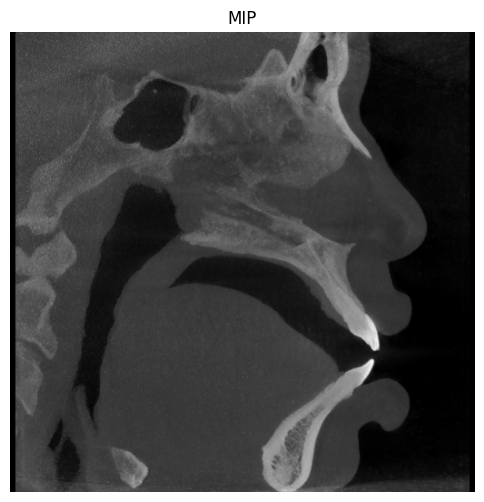

In [ ]:
# Maximum Intensity Projection (MIP)
plt.figure(figsize=(6,6))
plt.imshow(MIP_silla_nasion, 'gray')
plt.title("MIP")
plt.axis(False)

(-0.5, 511.5, 506.5, -0.5)

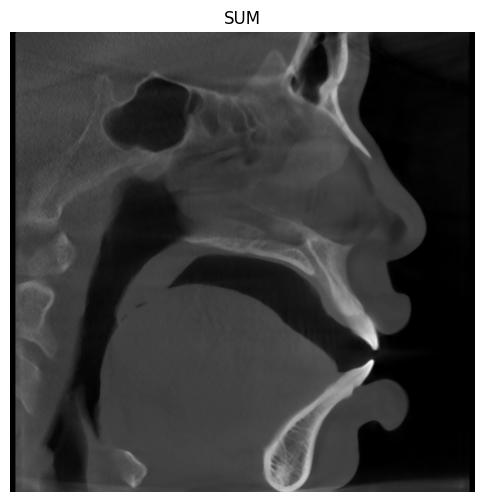

In [ ]:
# Visualization of Sum Intensity Projection (SUM)
plt.figure(figsize=(6,6))
plt.imshow(SUM_silla_nasion, 'gray')
plt.title("SUM")
plt.axis(False)

### Image transformations

In [ ]:
# Rescale the intensity values of the MIP image to the range [0, 1]
# This enhances contrast and normalizes the image for further processing
img_rescaled = exposure.rescale_intensity(MIP_silla_nasion, out_range=(0, 1))

# Apply Adaptive Histogram Equalization (CLAHE)
# - Improves local contrast
# - clip_limit controls how much the histogram is limited to avoid over-enhancement
equalized_adapthist_image = exposure.equalize_adapthist(img_rescaled, clip_limit=0.01)

# Compute the histogram of the equalized image
# - hist3 stores the frequency of pixel intensities
# - hist_centers3 stores the corresponding intensity values
hist3, hist_centers3 = exposure.histogram(equalized_adapthist_image)

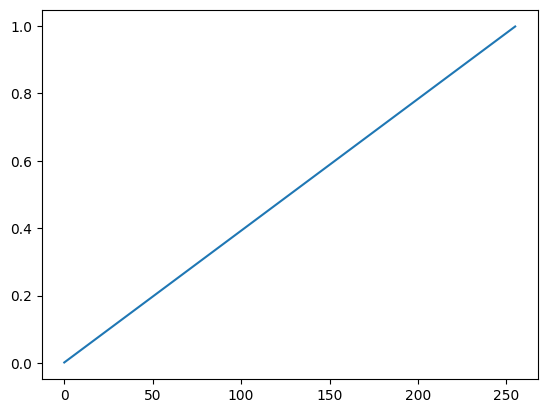

In [ ]:
plt.plot(hist_centers3)

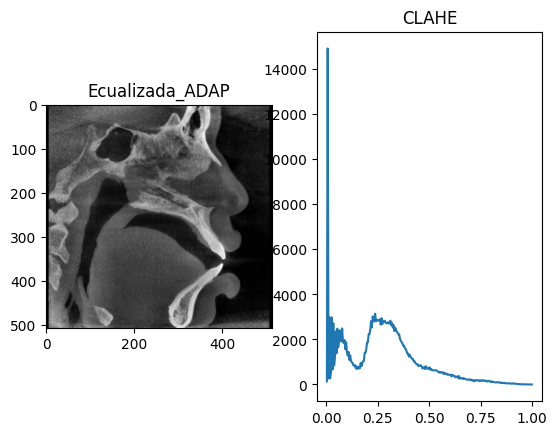

In [ ]:
# Display the equalized image and its histogram
plt.subplot(1, 2, 1), plt.imshow(equalized_adapthist_image, cmap='gray'), plt.title('Ecualizada_ADAP')
plt.subplot(1, 2, 2), plt.plot(hist_centers3, hist3), plt.title('CLAHE')
plt.show()

In [ ]:
# Ensure kernel_size exists and is valid for smoothing hist3
try:
    kernel_size
except NameError:
    kernel_size = 5  # default if not defined

# Make sure it's an integer
kernel_size = int(kernel_size)

# Force odd window length (Savitzky–Golay requires odd window_length)
if kernel_size % 2 == 0:
    kernel_size += 1

# Ensure window is not larger than the histogram (leave at least poly_order+1 points)
min_allowed = 5   # optional minimum sensible window
max_allowed = len(hist3) - 1 if (len(hist3) - 1) % 2 == 1 else len(hist3) - 2
if kernel_size < min_allowed:
    kernel_size = min_allowed if min_allowed % 2 == 1 else min_allowed + 1
if kernel_size > max_allowed:
    kernel_size = max_allowed if max_allowed % 2 == 1 else max_allowed - 1

# Apply Savitzky–Golay smoothing (poly order = 3)
smoothed_hist = savgol_filter(hist3, kernel_size, 3)

([<matplotlib.lines.Line2D at 0x7cce96f549d0>], Text(0.5, 1.0, 'CLAHE'))

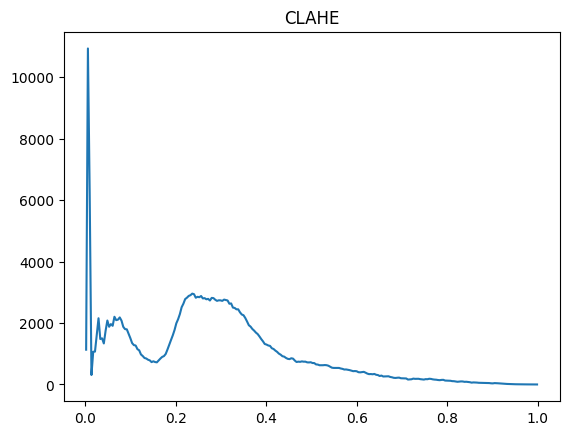

In [ ]:
# Display the histogram
plt.plot(hist_centers3, smoothed_hist), plt.title('CLAHE')

In [ ]:
# Smooth using a Gaussian-like kernel (here a simple moving average)
try:
    kernel_size
except NameError:
    kernel_size = 5  # default if not defined

# Ensure kernel_size is an integer
kernel_size = int(kernel_size)

# Ensure kernel_size is at least 1 and not larger than the histogram length
if kernel_size < 1:
    kernel_size = 1
if kernel_size > len(hist3):
    kernel_size = len(hist3)

# Create the smoothing kernel
kernel = np.ones(kernel_size) / kernel_size

# Apply convolution to smooth the histogram
smoothed_hist2 = np.convolve(hist3, kernel, mode='same')

In [ ]:
# Prepare data for KMeans clustering (combine histogram centers and smoothed histogram values)
data = np.column_stack([hist_centers3, smoothed_hist2])

# Apply KMeans with 3 clusters to segment the histogram
kmeans = KMeans(n_clusters=3).fit(data)

# Sort the cluster centers based on their x-axis (histogram center values)
cluster_centers = sorted(kmeans.cluster_centers_[:, 0])

# Define the threshold as the average of the cluster centers
threshold = np.mean(cluster_centers)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


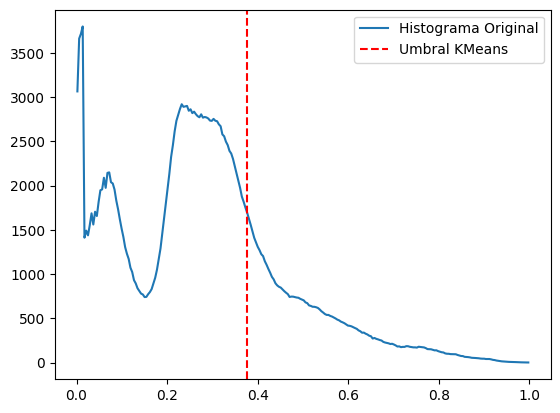

In [ ]:
# Display histogram with the KMeans threshold
plt.plot(hist_centers3, smoothed_hist2, label="Histograma Original")
plt.axvline(threshold, color='red', linestyle='--', label="Umbral KMeans")
plt.legend()
plt.show()

### Nose point

In [ ]:
# Apply bilateral denoising to reduce noise while preserving edges
SUM_nasion = denoise_bilateral(SUM_silla_nasion, sigma_color=0.05, sigma_spatial=8, channel_axis=None)

# Rescale the intensity values to the range [0, 1]
img_rescaled_sum = exposure.rescale_intensity(SUM_nasion, out_range=(0, 1))

# Assign the rescaled image to a variable for further processing
imagen = img_rescaled_sum

# Function to calculate image contrast (difference between max and min intensity)
def calcular_contraste(imagen):
    return imagen.max() - imagen.min()

# Objective function for optimization (maximize contrast by minimizing its negative value)
def objetivo(gamma):
    imagen_corregida = exposure.adjust_gamma(imagen, gamma)
    return -calcular_contraste(imagen_corregida)

# Optimize gamma value within [0.1, 2.0] to maximize image contrast
resultado = minimize_scalar(objetivo, bounds=(0.1, 2.0), method='bounded')

# Get the optimal gamma value
gamma_optimo = resultado.x

# Apply optimal gamma correction to the image
imagen_corregida = exposure.adjust_gamma(imagen, gamma_optimo)

# Normalize the corrected image to [0, 255]
imagen_normalizada = exposure.rescale_intensity(imagen_corregida, out_range=(0, 255))

# Apply adaptive histogram equalization to enhance local contrast
img_adapteq3 = exposure.equalize_adapthist(imagen_corregida)

(-0.5, 511.5, 506.5, -0.5)

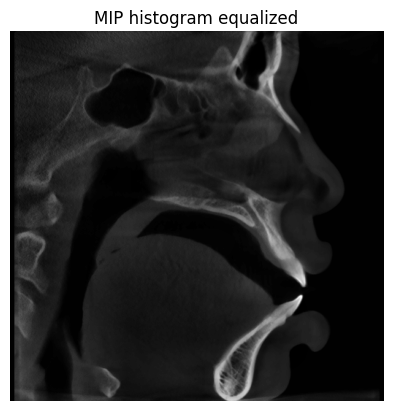

In [ ]:
# Display the MIP with the histogram equalized
plt.imshow(img_adapteq3,"gray")
plt.title("MIP histogram equalized")
plt.axis(False)

In [ ]:
# Prepare the data for KMeans by stacking histogram centers and smoothed values into columns
# This allows KMeans to detect intensity-based clusters in the image histogram.
data = np.column_stack([hist_centers3, smoothed_hist2])

# Apply KMeans clustering with 1 cluster to estimate the main intensity distribution
# Using 1 cluster here helps to determine the dominant brightness/intensity level of the region of interest.
kmeans = KMeans(n_clusters=1).fit(data)

# Extract and sort the cluster centers (intensity values)
cluster_centers = sorted(kmeans.cluster_centers_[:, 0])

# Define the threshold as the mean of the cluster centers minus an offset.
# The offset of 0.35 is introduced to slightly lower the threshold,
# ensuring the algorithm captures more subtle structures (e.g., bone edges or anatomical landmarks)
# that might lie below the peak intensity. This improves sensitivity in segmentation
# without drastically including background noise.
threshold1 = (np.mean(cluster_centers)) - 0.35

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


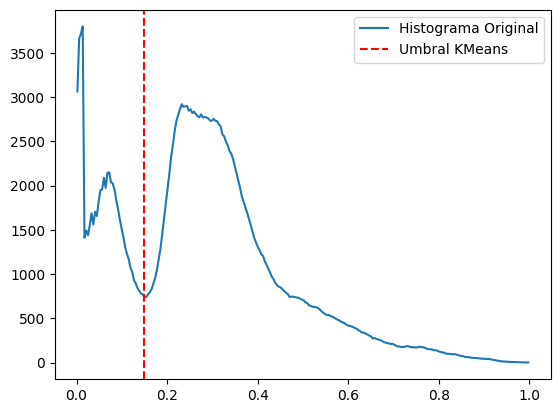

In [ ]:
# Display the histogram with the new threshold
plt.plot(hist_centers3, smoothed_hist2, label="Histograma Original")
plt.axvline(threshold1, color='red', linestyle='--', label="Umbral KMeans")
plt.legend()
plt.show()

In [ ]:
# Apply a binary threshold to the equalized image.
# Pixels with intensity values greater than 'threshold1' are set to True (foreground),
# while the rest are set to False (background).
# This step segments the image based on the threshold previously adjusted with the offset (0.35),
# allowing for better capture of key anatomical structures.
umbral3 = equalized_adapthist_image > threshold1

In [ ]:
# Define coordinates of the upper rectangle (region to be removed)
x1, y1 = 0, 0
x2, y2 = 512, 80

# Define coordinates of the lower rectangle (region to be removed)
v1, b1 = 0, 450
v2, b2 = 512, 512

# Threshold the adaptively equalized image to create a binary mask
# Pixels above 0.02 are set to True (foreground), highlighting relevant structures
cleaned_img_mip1 = img_adapteq3 > 0.02

# Mask out the upper rectangular region (e.g., irrelevant background area)
# This helps reduce noise or artifacts that could affect further processing
cleaned_img_mip1[y1:y2, x1:x2] = 0  # or False for boolean arrays

# Mask out the lower rectangular region to remove undesired background as well
cleaned_img_mip1[b1:b2, v1:v2] = 0  # or False for boolean arrays

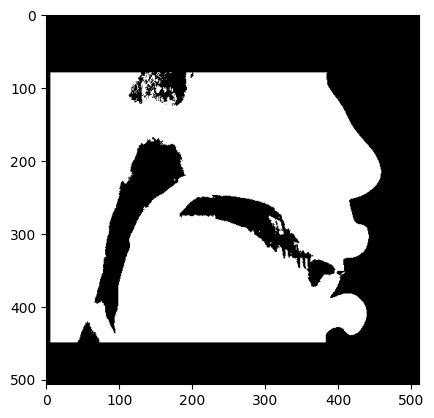

In [ ]:
# Visualization of the edited image
plt.imshow(cleaned_img_mip1, 'gray')
plt.show()

In [ ]:
def find_point(mask):
    # Find the indices (y, x) of all pixels where the mask has a value greater than 0
    y_indices, x_indices = np.where(mask > 0)

    # If there are no points in the mask, return None
    if len(y_indices) == 0 or len(x_indices) == 0:
        return None

    # Get the maximum y value (this corresponds to the lowest point in the image vertically)
    max_y = np.max(y_indices)

    # Get the maximum x value (this corresponds to the rightmost point in the image horizontally)
    max_x = np.max(x_indices)

    # Filter y_indices for the pixels that have the maximum x value
    y_values_for_max_x = y_indices[x_indices == max_x]

    # From those y values, select the minimum one (highest position at the rightmost x)
    max_x_for_min_y = np.min(y_values_for_max_x)

    # Return the coordinates as (x, y) — following the conventional order
    return (max_x, max_x_for_min_y)

In [ ]:
# Use the find_point function to locate the anatomical reference point on the cleaned image
point_nariz = find_point(cleaned_img_mip1)

# Print the coordinates of the detected point
print(point_nariz)

(458, 213)


In [ ]:
# Unpack the nasal point coordinates returned by find_point
# x_nariz corresponds to the x-coordinate, and y_nariz to the y-coordinate
x_nariz, y_nariz = point_nariz

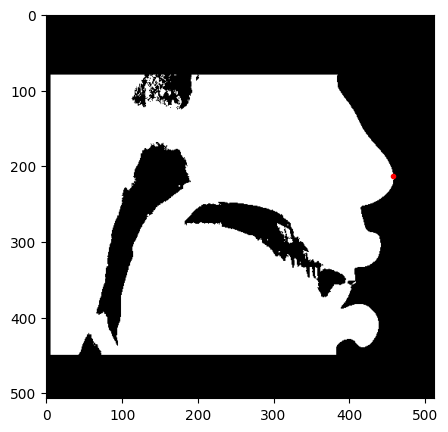

In [ ]:
# Visualization of the nasal point
plt.figure(figsize=(5,5))
plt.imshow(cleaned_img_mip1, cmap="gray")

plt.scatter(x_nariz, y_nariz, color='red', marker='o', s=9)
plt.show()

### Soft pogonion point

In [ ]:
# Define top rectangular crop area (coordinates)
x1, y1 = 0, 0
x2, y2 = 512, 480

# Define bottom rectangular crop area (coordinates)
v1, b1 = 400, 450
v2, b2 = 512, 512

# Create a binary mask by thresholding the normalized image
# All pixel values > 15 become True (1), others False (0)
cleaned_img_mip2 = imagen_normalizada > 15

# Apply rectangular cropping to remove unwanted regions
cleaned_img_mip2[y1:y2, x1:x2] = 0  # Mask out top area
cleaned_img_mip2[b1:b2, v1:v2] = 0  # Mask out bottom area

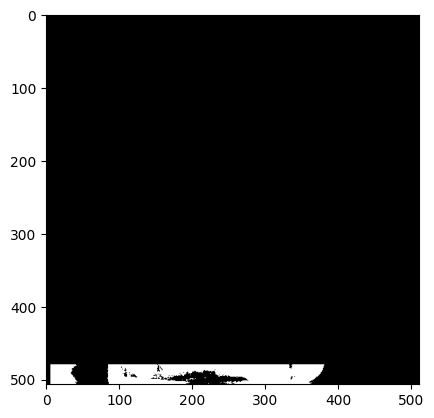

In [ ]:
# Display the modified binary mask
plt.imshow(cleaned_img_mip2, 'gray')
plt.show()

In [ ]:
# Use the same function 'find_point' to detect the key landmark point
# from the binary mask created for the soft pogonion region.
point_pogb = find_point(cleaned_img_mip2)

# Print the coordinates of the detected soft pogonion point
print(point_pogb)

(380, 480)


In [ ]:
# Unpack the coordinates of the detected soft pogonion point
# x_pogb → x-coordinate of the soft pogonion
# y_pogb → y-coordinate of the soft pogonion
x_pogb, y_pogb = point_pogb

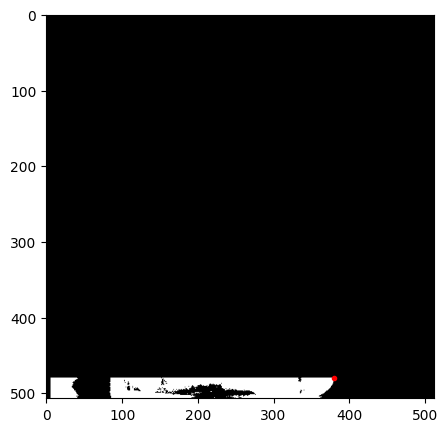

In [ ]:
# Visualization of the soft pogonion point
plt.figure(figsize=(5,5))
plt.imshow(cleaned_img_mip2, cmap="gray")

plt.scatter(x_pogb, y_pogb, color='red', marker='o', s=9)  # Adjust the color, marker, and size to your liking
plt.show()

### Ricketts line plotting

In [ ]:
# Define the coordinates (x, y) of two anatomical landmarks:
# x1, y1 = nasal point; x2, y2 = soft pogonion point
x1, y1 = 458, 213
x2, y2 = 380, 480

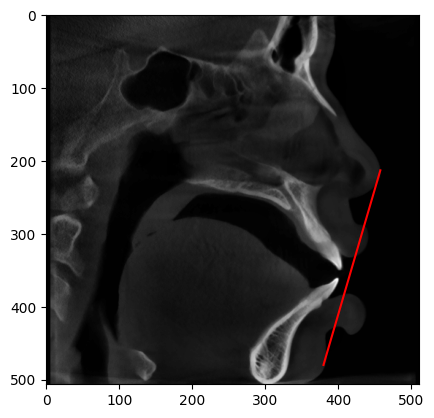

In [ ]:
# Draw a red line between the nasal and soft pogonion points
# This represents the Ricketts line used in cephalometric analysis
plt.figure()
plt.plot([x1, x2], [y1, y2], color='red')

# Display the reference image (adapted image) in grayscale
plt.imshow(img_adapteq3, cmap='gray')

# Show the image with the plotted line
plt.show()

### Automatic method

In [ ]:
def ubicacion_automatica(MIP_silla_nasion, SUM_silla_nasion):
    # === Preprocessing MIP image ===
    # Normalize image intensity to [0, 1]
    img_rescaled = exposure.rescale_intensity(MIP_silla_nasion, out_range=(0, 1))

    # Enhance local contrast using adaptive histogram equalization (CLAHE)
    equalized_adapthist_image = exposure.equalize_adapthist(img_rescaled, clip_limit=0.01)

    # Compute the image histogram
    hist3, hist_centers3 = exposure.histogram(equalized_adapthist_image)

    # === Smooth the histogram ===
    kernel_size = 5
    kernel = np.ones(kernel_size) / kernel_size
    smoothed_hist2 = np.convolve(hist3, kernel, mode='same')

    # === Preprocessing SUM image ===
    # Apply bilateral filter to reduce noise while preserving edges
    SUM_nasion = denoise_bilateral(SUM_silla_nasion, sigma_color=0.05, sigma_spatial=8, channel_axis=None)

    # Normalize intensity to [0, 1]
    img_rescaled_sum = exposure.rescale_intensity(SUM_nasion, out_range=(0, 1))
    imagen = img_rescaled_sum

    # --- Function to calculate image contrast ---
    def calcular_contraste(imagen):
        return imagen.max() - imagen.min()

    # --- Objective function to find optimal gamma ---
    def objetivo(gamma):
        imagen_corregida = exposure.adjust_gamma(imagen, gamma)
        # Return negative contrast so the optimizer maximizes it
        return -calcular_contraste(imagen_corregida)

    # === Gamma optimization ===
    # Find the gamma that maximizes image contrast
    resultado = minimize_scalar(objetivo, bounds=(0.1, 2.0), method='bounded')
    gamma_optimo = resultado.x

    # Apply optimal gamma correction
    imagen_corregida = exposure.adjust_gamma(imagen, gamma_optimo)

    # Normalize intensity to [0, 255] for segmentation
    imagen_normalizada = exposure.rescale_intensity(imagen_corregida, out_range=(0, 255))

    # Apply CLAHE again after gamma correction
    img_adapteq3 = exposure.equalize_adapthist(imagen_corregida)

    # --- Helper function to find anatomical point ---
    def find_point(mask):
        # Find coordinates where the mask > 0
        y_indices, x_indices = np.where(mask > 0)

        # Return None if no points found
        if len(y_indices) == 0 or len(x_indices) == 0:
            return None

        # Find max x (posterior-most point)
        max_x = np.max(x_indices)

        # Get y values corresponding to that x
        y_values_for_max_x = y_indices[x_indices == max_x]

        # Choose min y among those values (most superior point)
        max_x_for_min_y = np.min(y_values_for_max_x)

        return (max_x, max_x_for_min_y)

    # --- Function to detect nasal point ---
    def punto_nariz(img_adapteq3, hist_centers3, smoothed_hist2):
        # Cluster histogram values to estimate a threshold
        data = np.column_stack([hist_centers3, smoothed_hist2])
        kmeans = KMeans(n_clusters=1).fit(data)

        cluster_centers = sorted(kmeans.cluster_centers_[:, 0])
        threshold1 = (np.mean(cluster_centers)) - 0.35  # threshold adjustment

        umbral3 = equalized_adapthist_image > threshold1

        # --- Crop top and bottom regions (not needed for point detection) ---
        x1, y1 = 0, 0
        x2, y2 = 512, 80
        v1, b1 = 0, 450
        v2, b2 = 512, 512

        cleaned_img_mip1 = img_adapteq3 > 0.02
        cleaned_img_mip1[y1:y2, x1:x2] = 0  # remove top
        cleaned_img_mip1[b1:b2, v1:v2] = 0  # remove bottom

        # Find nasal point on the mask
        point_nariz = find_point(cleaned_img_mip1)

        return point_nariz

    # --- Function to detect soft pogonion point ---
    def punto_pogonion_blando(img_adapteq3, hist_centers3, smoothed_hist2):
        # Define crop region
        x1, y1 = 0, 0
        x2, y2 = 512, 480
        v1, b1 = 400, 450
        v2, b2 = 512, 512

        cleaned_img_mip2 = imagen_normalizada > 15

        # Crop unwanted regions
        cleaned_img_mip2[y1:y2, x1:x2] = 0
        cleaned_img_mip2[b1:b2, v1:v2] = 0

        # Find pogonion point on the mask
        point_pogb = find_point(cleaned_img_mip2)

        return point_pogb

    # === Get nasal and soft pogonion points ===
    point_nariz = punto_nariz(img_adapteq3, hist_centers3, smoothed_hist2)
    point_pogb = punto_pogonion_blando(img_adapteq3, hist_centers3, smoothed_hist2)

    x1, y1 = point_nariz
    x2, y2 = point_pogb

    print("Coordenadas punto nariz", point_nariz)
    print("Coordenadas punto pogonion blando:", point_pogb)

    # === Visualization ===
    plt.figure(figsize=(10, 10))

    # Draw a red line between nasal and soft pogonion points (Ricketts line)
    plt.plot([x1, x2], [y1, y2], color='red')

    # Mark the points with red circles and labels
    plt.scatter(x1, y1, color='red', marker='o', s=9)
    plt.text(x1, y1, "P", color="red", horizontalalignment='right')
    plt.scatter(x2, y2, color='red', marker='o', s=9)
    plt.text(x2, y2, "Pog'", color="red", horizontalalignment='right')

    # Display the processed image with the plotted line
    plt.imshow(img_adapteq3, cmap='gray')
    plt.axis(False)
    plt.show()

Coordenadas punto nariz: (458, 213)
Coordenadas punto pogonion blando:  (380, 480)


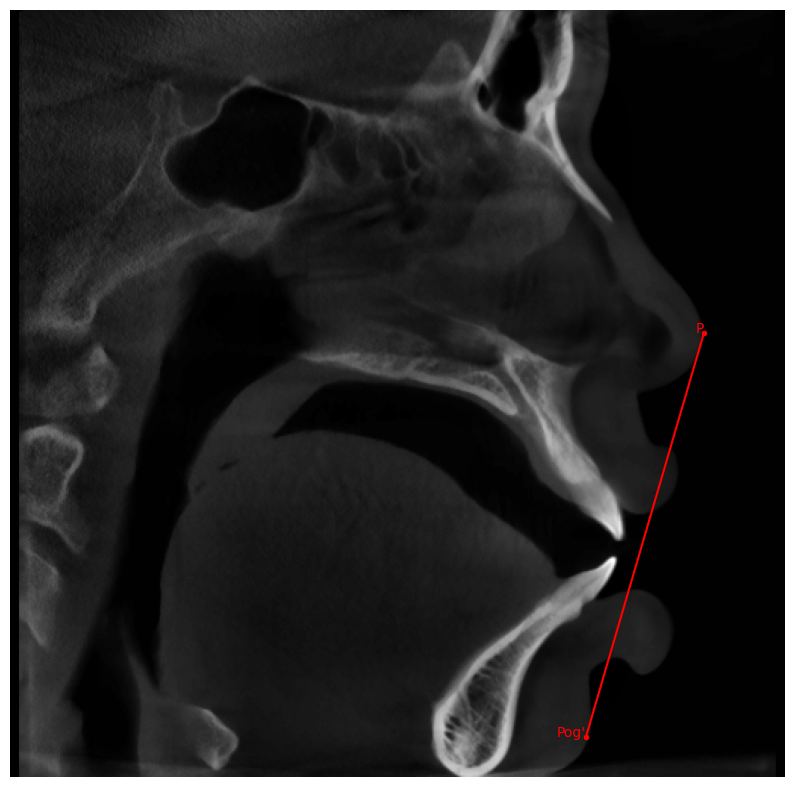

In [ ]:
e_line = ubicacion_automatica(MIP_silla_nasion, SUM_silla_nasion)